# Water flux within the root 

by Daniel Leitner, Andrea Schnepf 

## Model derivation


Roughly based on Roose and Fowler (2004) and Doussan et al. (2006).


The axial water flux in a xylem is given by 
\begin{eqnarray} 
q_z = - k_z \left( \frac{\partial p_r}{\partial z} - \rho g e_z \cdot v \right), \label{axialflux}
\end{eqnarray}
with units [L$^3$ T$^{-1}$] (see Eqn 3.1 Roose and Fowler, 2004). 
The parameter $k_z$ is the axial conductance [$L^5$ T M$^{-1}$], 
$p_r$ is the pressure inside the xylem [M L$^{-1}$ T$^{-2}$], 
$\rho$ is the density of water [M L$^{-3}$], 
$g$ is the gravitational acceleration [L T$^{-2}$], 
$e_z$ the downward unit vector [1],
and $v$ the normed direction of the xylem [1]. Thus Eqn \ref{axialflux} can be expressed as
\begin{eqnarray}
q_z = - k_z \left( \frac{\partial p_r}{\partial z} + \rho g v_3 \right), \label{axialflux2}
\end{eqnarray}
where $v_3$ is the $z$-component of the normed xylem direction. \\

\noindent
The radial flux is given by 
\begin{eqnarray}
q_r = - 2 a \pi l k_r (p_s - p_r),
\end{eqnarray}
with units [L$^3$ T$^{-1}$] (based on Eqn 3.3 Roose and Fowler, 2004), 
where $a$ is the root radius [L], $l$ is the segments length [L], 
$k_r$ is the radial conductance [L$^2$ T M$^{-1}$], 
and $p_s$ is the pressure of the surrounding soil [M L$^{-1}$ T$^{-2}$]. \\

\noindent
The net flux is given by
\begin{eqnarray}
q = q_z + q_r,
\end{eqnarray} 
and mass conservation yields
\begin{eqnarray}
2 a \pi k_r (p_s - p_r) = - k_z \frac{\partial^2 p_r}{\partial z^2} \label{masscons}
\end{eqnarray}
(see Eqn 3.4 Roose and Fowler, 2004).

\noindent
For discretisation we use first Kirchhoff's law: In a graph that represents the root system for each node $i$ the sum of fluxes must be zero 
\begin{eqnarray}
\sum_{j \in N(i)} q_{ij} = 0,  \label{KH}
\end{eqnarray}
where $N(i)$ are the nodes that are connected to node $i$ and $q_{ij}$ is the net flux of the edge connecting node $i$ and node $j$.


## Benchmark 1: A single root in static soil 

For the first benchmark problem we assume a vertical single straight root segment surrounded by a soil with a constant soil pressure. 

For constant $k_r$ and $k_z$ we can solve Eqn \ref{masscons} yielding 
\begin{eqnarray}
p_r(z) := p_s + d_1 e^{\sqrt{c} z } + d_2 e^{-\sqrt{c} z} \label{analytic_flux}
\end{eqnarray} 
with $c = 2 a \pi k_r / k_z$. 

The constants $d_1$, and $d_2$ [M L$^{-1}$ T$^{-2}$] are calculated from the boundary conditions.

First some imports:

In [1]:
from math import *
import numpy as np
import matplotlib.pylab as plt

g = 9.81 # gravitational acceleration (m/s^2)   
rho = 1.e3 # density of water, (kg/m^3)      
ref = 1.e5 # reference pressure (kg/ (m s^2))

def toPa(ph): # cm pressure head to Pascal (kg/ (m s^2))
    return ref + ph / 100. * rho * g

def toHead(pa): # Pascal (kg/ (m s^2)) to cm pressure head
    return (pa-ref) * 100 / rho / g

Next we pick the parameters

In [2]:
# Parameters
L = 0.5                # length of single straight root (m)
a = 2.e-3              # radius (m)
kz = 5.e-13            # axial conductivity (m^5 s / kg) (mal rho ergibt die alten einheiten)
kr = 2.e-9             # radial conductivity per root type (m^2 s / kg) 
p_s = toPa(-200)       # static soil pressure (cm) 
p0 = toPa(-1000)       # dircichlet bc at top

# Analytical solution
c = 2*a*pi*kr/kz
p_r = lambda z: toHead( p_s + d[0]*exp(sqrt(c)*z) + d[1]*exp(-sqrt(c)*z) )

The Dirichlet boundary conditions at the top $p_r(0) = p_0$ is inserted into the analytic soltution Eqn (\ref{analytic_flux}), and yields
\begin{eqnarray}
p_s + d_1  + d_2  = p_0.
\end{eqnarray}

The Neumann boundary conition $q_z(L) = 0$ (Eqn \ref{axialflux2}) leads to 
\begin{eqnarray}
\frac{\partial p_r}{\partial z} (L) = \rho g v_3.
\end{eqnarray}
Using the derivation of the analytical solution yields
\begin{eqnarray}
d_1 \sqrt{c} e^{\sqrt{c} L } - d_2 \sqrt{c} e^{-\sqrt{c} L}  = \rho g v_3.
\end{eqnarray}


Therefore, we solve 
\begin{align}
\left(\begin{array}{cc}
  1 & 1  \\
 \sqrt{c} \exp{(\sqrt{c} L)} & -\sqrt{c} \exp{(-\sqrt{c} L)} \\
\end{array}\right)
\left(\begin{array}{c}
  d_{1}  \\
  d_{2}  \\
\end{array}\right)
{} &= 
\left(\begin{array}{c}  
  p0-p_s \\
  -\rho g \\
\end{array}\right)
\end{align}

We recalculate the constants $d_1$, and $d_2$, and plot the results

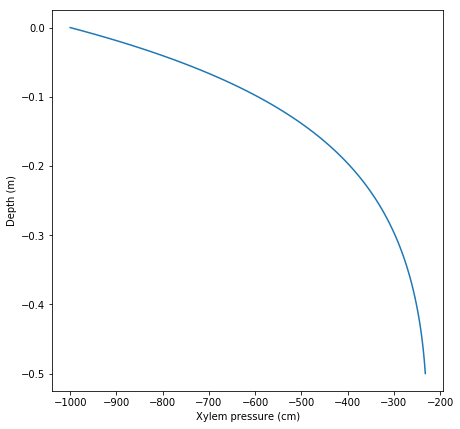

In [3]:
# Boundary conditions
AA = np.array([[1,1], [sqrt(c)*exp(sqrt(c)*(-L)), -sqrt(c)*exp(-sqrt(c)*(-L))] ]) # dirichlet top, neumann bot
bb = np.array([p0-p_s, -rho*g]) #
d = np.linalg.solve(AA, bb) # compute constants d_1 and d_2 from bc

# Plot results
fig=plt.figure(figsize=(7, 7))
za_ = np.linspace(0,-L,100)
pr = list(map(p_r, za_))
plt.plot(pr,za_)
plt.xlabel("Xylem pressure (cm)")
plt.ylabel("Depth (m)")
plt.show()

## Benchmark 2: A small root system in a static soil

In the following we will give a small static root system which is eight days old described by nodes (in cm) and segments (two node indices). For each node we give the age (in days), and for each segment the type which is either 0 for tap root or 1 for lateral root. Furthermore, the radius is constant for tap, and lateral roots (in cm). 

In [4]:
nodes = np.array([ [0.00,0.00,-3.00], [-0.00,-0.01,-3.48], [-0.85,0.48,-3.71], [-1.69,0.99,-3.90], [-2.58,1.32,-4.21], [-3.48,1.67,-4.49], [-4.38,2.00,-4.77], [-5.24,2.40,-5.09], [-6.08,2.82,-5.42], [-6.93,3.27,-5.69], [-6.96,3.29,-5.70], [-0.00,0.01,-3.97], [0.20,-0.95,-4.20], [0.43,-1.88,-4.49], [0.65,-2.81,-4.77], [0.84,-3.75,-5.06], [1.04,-4.70,-5.31], [1.27,-5.64,-5.54], [1.43,-6.58,-5.84], [1.48,-6.91,-5.94], [-0.01,0.03,-4.45], [0.75,0.68,-4.48], [1.52,1.32,-4.50], [2.30,1.94,-4.46], [3.07,2.58,-4.41], [3.88,3.16,-4.46], [4.73,3.69,-4.50], [5.34,4.05,-4.53], [-0.03,0.06,-4.97], [-0.73,0.63,-5.40], [-1.46,1.20,-5.79], [-2.15,1.80,-6.18], [-2.76,2.48,-6.59], [-3.16,3.16,-7.21], [-3.63,3.90,-7.64], [-0.06,0.07,-5.42], [0.07,1.04,-5.61], [0.23,2.00,-5.82], [0.46,2.93,-6.11], [0.72,3.85,-6.40], [0.99,4.77,-6.69], [1.06,5.11,-6.78], [-0.10,0.08,-5.96], [0.35,0.90,-6.31], [0.80,1.72,-6.65], [1.23,2.55,-7.01], [1.62,3.41,-7.34], [1.70,3.58,-7.41], [-0.14,0.10,-6.46], [0.05,-0.81,-6.83], [0.29,-1.72,-7.18], [0.43,-2.62,-7.59], [0.50,-3.12,-7.84], [-0.19,0.12,-7.02], [0.32,0.98,-7.03], [0.82,1.84,-6.95], [1.07,2.23,-6.88], [-0.23,0.17,-7.56], [0.68,-0.18,-7.80], [1.12,-0.35,-7.93], [-0.24,0.21,-8.14], [-0.01,0.36,-8.22], [-0.25,0.24,-8.69], [-0.24,0.25,-9.25], [-0.24,0.26,-9.71], [-0.26,0.26,-10.09], [-0.28,0.25,-10.57], [-0.26,0.24,-11.05], [-0.26,0.21,-11.58], [-0.25,0.19,-12.06], [-0.25,0.17,-12.55], [-0.23,0.15,-13.00], [-0.23,0.12,-13.46], [-0.22,0.12,-13.99], [-0.21,0.15,-14.54], [-0.19,0.20,-15.07], [-0.17,0.24,-15.60], [-0.17,0.31,-16.17], [-0.15,0.36,-16.64], [-0.12,0.43,-17.18], [-0.11,0.48,-17.70], [-0.07,0.52,-18.23], [-0.06,0.53,-18.53] ])
seg = np.array([ [0,1], [1,11], [11,20], [20,28], [28,35], [35,42], [42,48], [48,53], [53,57], [57,60], [60,62], [62,63], [63,64], [64,65], [65,66], [66,67], [67,68], [68,69], [69,70], [70,71], [71,72], [72,73], [73,74], [74,75], [75,76], [76,77], [77,78], [78,79], [79,80], [80,81], [81,82], [1,2], [2,3], [3,4], [4,5], [5,6], [6,7], [7,8], [8,9], [9,10], [11,12], [12,13], [13,14], [14,15], [15,16], [16,17], [17,18], [18,19], [20,21], [21,22], [22,23], [23,24], [24,25], [25,26], [26,27], [28,29], [29,30], [30,31], [31,32], [32,33], [33,34], [35,36], [36,37], [37,38], [38,39], [39,40], [40,41], [42,43], [43,44], [44,45], [45,46], [46,47], [48,49], [49,50], [50,51], [51,52], [53,54], [54,55], [55,56], [57,58], [58,59], [60,61] ])
age = np.array([ 8.00,7.76,7.52,7.29,7.03,6.80,6.53,6.28,6.00,5.73,5.43,5.16,4.87,4.64,4.44,4.20,3.95,3.68,3.43,3.17,2.94,2.70,2.42,2.14,1.85,1.57,1.27,1.02,0.73,0.45,0.16,-0.00,2.29,2.02,1.74,1.43,1.11,0.77,0.41,0.01,0.00,2.04,1.77,1.48,1.18,0.85,0.51,0.14,0.00,1.78,1.51,1.22,0.92,0.60,0.26,0.00,1.51,1.24,0.96,0.66,0.34,0.00,1.28,1.01,0.73,0.43,0.12,0.00,0.97,0.69,0.39,0.07,0.00,0.72,0.45,0.17,0.00,0.41,0.14,0.00,0.13,0.00,0.00 ])
types = np.array([ 1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2 ])
a_tap = 0.2 # tap root radius (cm)
a_lateral = 0.1 # lateral root radius (cm)

We can visualize the small root system by the following script, where colors denote the root type:

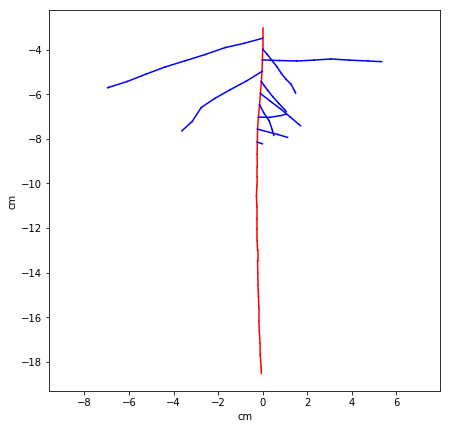

In [5]:
fig=plt.figure(figsize=(7, 7))
cols = ['r','b'] 
for i,s in enumerate(seg): 
    n1 = nodes[s[0]]
    n2 = nodes[s[1]]
    plt.plot([n1[0], n2[0]], [n1[2], n2[2]], cols[types[i]-1])    
plt.axis('equal')
plt.xlabel("cm")
plt.ylabel("cm")
plt.show()

For benchmark 2 we neglect root age and define static conductivities: 

$k_z$ = 1.e-18 [m$^4$/(Pa s)]

$k_r$ = 2.e-14 [m/(Pa s)]

At the root collar we assume -1000 cm pressure head located at node index 0, and a no-flux boundary condition at the root tips. The tip indices are given by:

In [7]:
def isTip(nid,seg):
    for s in seg[:,0]:
        if s==nid:
            return False
    return True

tipsI = ""
for i in range(0, len(nodes)):
    if isTip(i,np.array(seg)): 
        tipsI += str(i)+","    
print("tips = ["+tipsI[:-1]+"]")                    

tips = [10,19,27,34,41,47,52,56,59,61,82]


The soil is assumed to be static with a matric potential of -200 cm pressure head. The task of Benchmark 2 is to calculate the pressure in the segments and or nodes. 

Since there is no analytical solution available to the problem, we can validate numerical codes by inter-comparison. 

## Benchmark 3: A small root system in a static soil with dynamic conductivities

We will recalculate benchmark 2 with dynamic conductivities, that are given per segment age:

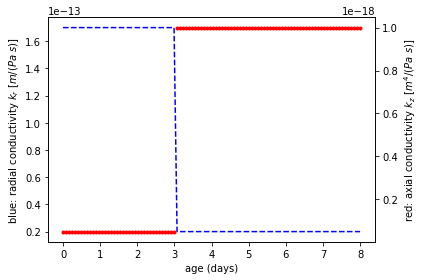

In [15]:
kz0, kz1 = 0.5e-19, 1.e-18 # m^4 / (Pa s)
kr0, kr1 = 1.7e-13, 0.2e-13 # m / (Pa s)
kz = lambda age: kz0*(age<=3)+kz1*(age>3)
kr = lambda age: kr0*(age<=3)+kr1*(age>3)

# Plot function
age_ = np.linspace(0,8,100)
fig, ax1 = plt.subplots()
ax1.plot(age_,list(map(kr, age_)), "b--")
ax1.set_xlabel("age (days)")
ax1.set_ylabel("blue: radial conductivity $k_r$ [$m/(Pa \ s)$]")
ax2 = ax1.twinx()
ax2.plot(age_,list(map(kz, age_)), "r.")
ax2.set_ylabel("red: axial conductivity $k_z$ [$m^4/(Pa \ s)$]")
fig.tight_layout()
plt.show()

TO DISCUSS: Actually, I can not think of anymore benchmarks concerning flux within the root system only. Since the flux model is static, root growth does not give any more information regarding the flux codes (or am i missing something).



## Comparison to numerical solutions

We plan to validate various numerical codes by solving the benchmarking problems 1 & 2. 

In the following we link to notebooks already containing Benchmark 1 and 2:

* [Homegrown Python Code from Schnepf et al. 2018](Xylem flux - Python code.ipynb)
* [Dumux](Xylem flux - Dumux.ipynb)


### Benchmark 1 

For an automatic comparison of the numerical results, save the results in a text file with two lines, containing comma separated depth values (m) in the first line, and pressure head (cm) in the second, located in the folder `/xylem_flux/b1/simulatorname`.

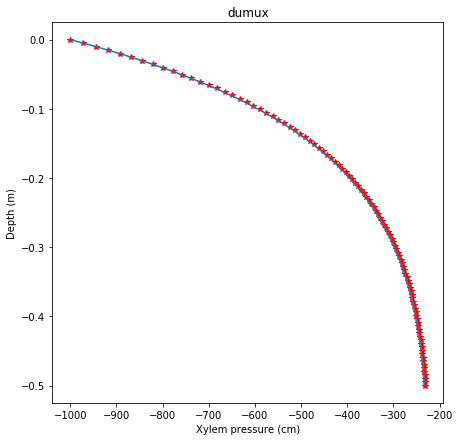

From -1000.0 to -230.885814857 cm pressure head
N =100
R² =0.999910473697


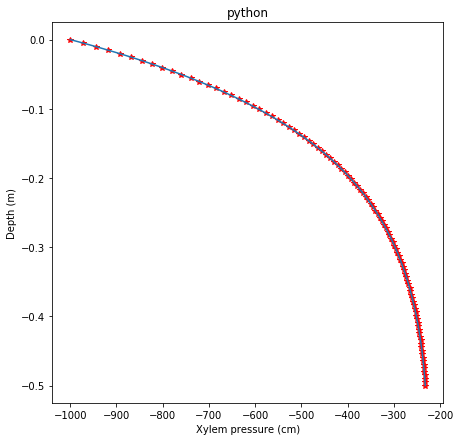

From -1000.0 to -232.056870696 cm pressure head
N =100
R² =0.999999986253


In [11]:
import os
# os.chdir("/home/daniel/Dokumente/collaborative-comparison")
wd = os.getcwd()
os.chdir("xylem_flux/b1")

# make plots for Benchmark 1
for dirname, dirnames, filenames in os.walk('.'):
    filenames.sort()
    for i,f in enumerate(filenames):
        data = np.loadtxt(f,delimiter=',')
        fig=plt.figure(figsize=(7, 7))    
        plt.plot(data[1,:],data[0,:],'r*') # numeric solution
        plt.xlabel("Xylem pressure (cm)")
        plt.ylabel("Depth (m)")
        plt.title(f)        
        plt.plot(pr,za_) # analytical solution
        pr_ = list(map(p_r, data[0,:]))            
        plt.show()
    
        # calculate R^2
        n = data.shape[1]
        r = 1 - ( np.sum(np.square(pr_-data[1,:])) / (np.sum(np.square(pr_))-np.square(np.sum(pr_))/n) )    
        print("From", min(data[1,:]), "to", max(data[1,:]), "cm pressure head")
        print("N =" + str(n))
        print("R² =" + str(r))

os.chdir(wd) # reset working directory

### Benchmark 2

For an inter-comparison of the numerical results save the results in a text file with two lines, containing comma separated depth values (m) in the first line, and pressure head (cm) in the second line. Locate the file in the folder `/xylem_flux/b2/simulatorname`.




1. python (r*):
from  -1000.0 to -268.059528864  cm pressure head

2. dumux (g*):
from  -1000.0 to -262.264032238  cm pressure head



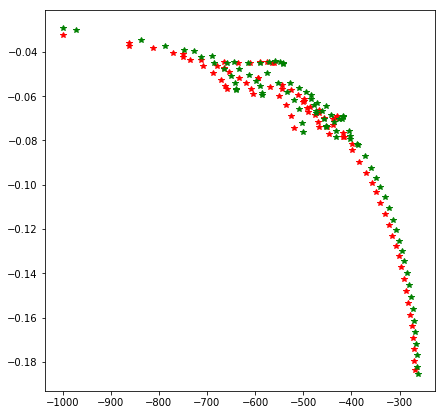

In [13]:
import os
wd = os.getcwd()
os.chdir("xylem_flux/b2")
fig=plt.figure(figsize=(7, 7))

col = ["r*", "g*", "b*","rv", "gv", "bv"]

for dirname, dirnames, filenames in os.walk('.'):
    for i,f in enumerate(filenames):
        data = np.loadtxt(f,delimiter=',')        
        print(str(i+1)+". "+f+" ("+col[i]+"):")
        print("from ", min(data[1,:]), "to", max(data[1,:]), " cm pressure head\n")        
        plt.plot(data[1,:],data[0,:],col[i])

plt.show()
        
os.chdir(wd) # reset working directory

### Benchmark 3

For an inter-comparison of the numerical results save the results in a text file with two lines, containing comma separated depth values (m) in the first line, and pressure head (cm) in the second line. Locate the file in the folder `/xylem_flux/b3/simulatorname`.

1. python (r*):
from  -1000.0 to -199.747119635  cm pressure head

2. dumux (g*):
from  -1000.0 to -201.955115953  cm pressure head



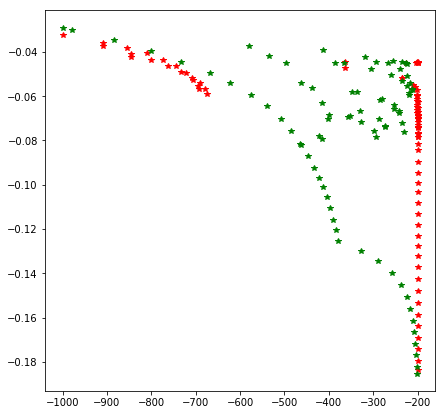

In [17]:
import os
wd = os.getcwd()
os.chdir("xylem_flux/b3")
fig=plt.figure(figsize=(7, 7))

col = ["r*", "g*", "b*","rv", "gv", "bv"]

for dirname, dirnames, filenames in os.walk('.'):
    for i,f in enumerate(filenames):
        data = np.loadtxt(f,delimiter=',')        
        print(str(i+1)+". "+f+" ("+col[i]+"):")
        print("from ", min(data[1,:]), "to", max(data[1,:]), " cm pressure head\n")        
        plt.plot(data[1,:],data[0,:],col[i])

plt.show()
        
os.chdir(wd) # reset working directory

There are huge differences between the approaches, python code seems to be wrong. 

## References

Doussan, C., Pierret, A., Garrigues, E., and Pages, L. (2006). Water uptake by plant roots: II - Modelling of water transfer in the soil root-system with explicit account of flow within the root system - comparison with experiments. *Plant and Soil*, 283(1-2):99–117.

Roose, T. and Fowler, A. C. (2004). A model for water uptake by plant roots. *Journal of Theoretical Biology*, 228(2):155–171.

Schnepf, A., Leitner, D., Landl, M., Lobet, G., Mai, T.H., Morandage S., Sheng, C., Zoerner, M., Vanderborght, J., Vereecken, H. (2018) CRootBox: a structural-functional modelling framework for root systems. *Annals of Botany*, 121 (5), 1033-1053
